# Translating Hyperbolic Function: Analyzing the Principal Components of the $R_X$ Data Matrix

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE   
from PCAfold         import PCA          as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
OutputDir       = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/TransTanh_100Cases/Orig/')
FigDir          = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet/')

Vars            = ['x']
NVars           = len(Vars)

n_ics           = 100
valid_perc      = 20

PCAType         = 'OneByOne'
mode_name       = '1'
iVar            = 0

n_modesFinal    = 8


ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir+'/'+str(PCAType))
except:
    pass

## Loading Training Data

In [3]:
Cols   = []
NewFlg = True
for iC in range(n_ics):

    FileName             = OutputDir+'/train/ext/y.csv.'+str(iC+1)
    Data                 = pd.read_csv(FileName, header=0)
    DataTemp             = Data[Vars[iVar]]

    if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-3):
        DataICTemp  = Data[Vars].iloc[0]

        if (NewFlg):
            DataInput        = DataTemp
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataInput        = pd.concat([DataInput, DataTemp], axis=1)
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
        Cols.append(str(iC+1))

tVec              = Data['t']
DataInput.columns = Cols

yMat              = DataInput.to_numpy()

DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [4]:
ICs = DataIC.to_numpy()

In [5]:
## Estimating the Required Number of Singular Values

/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j,

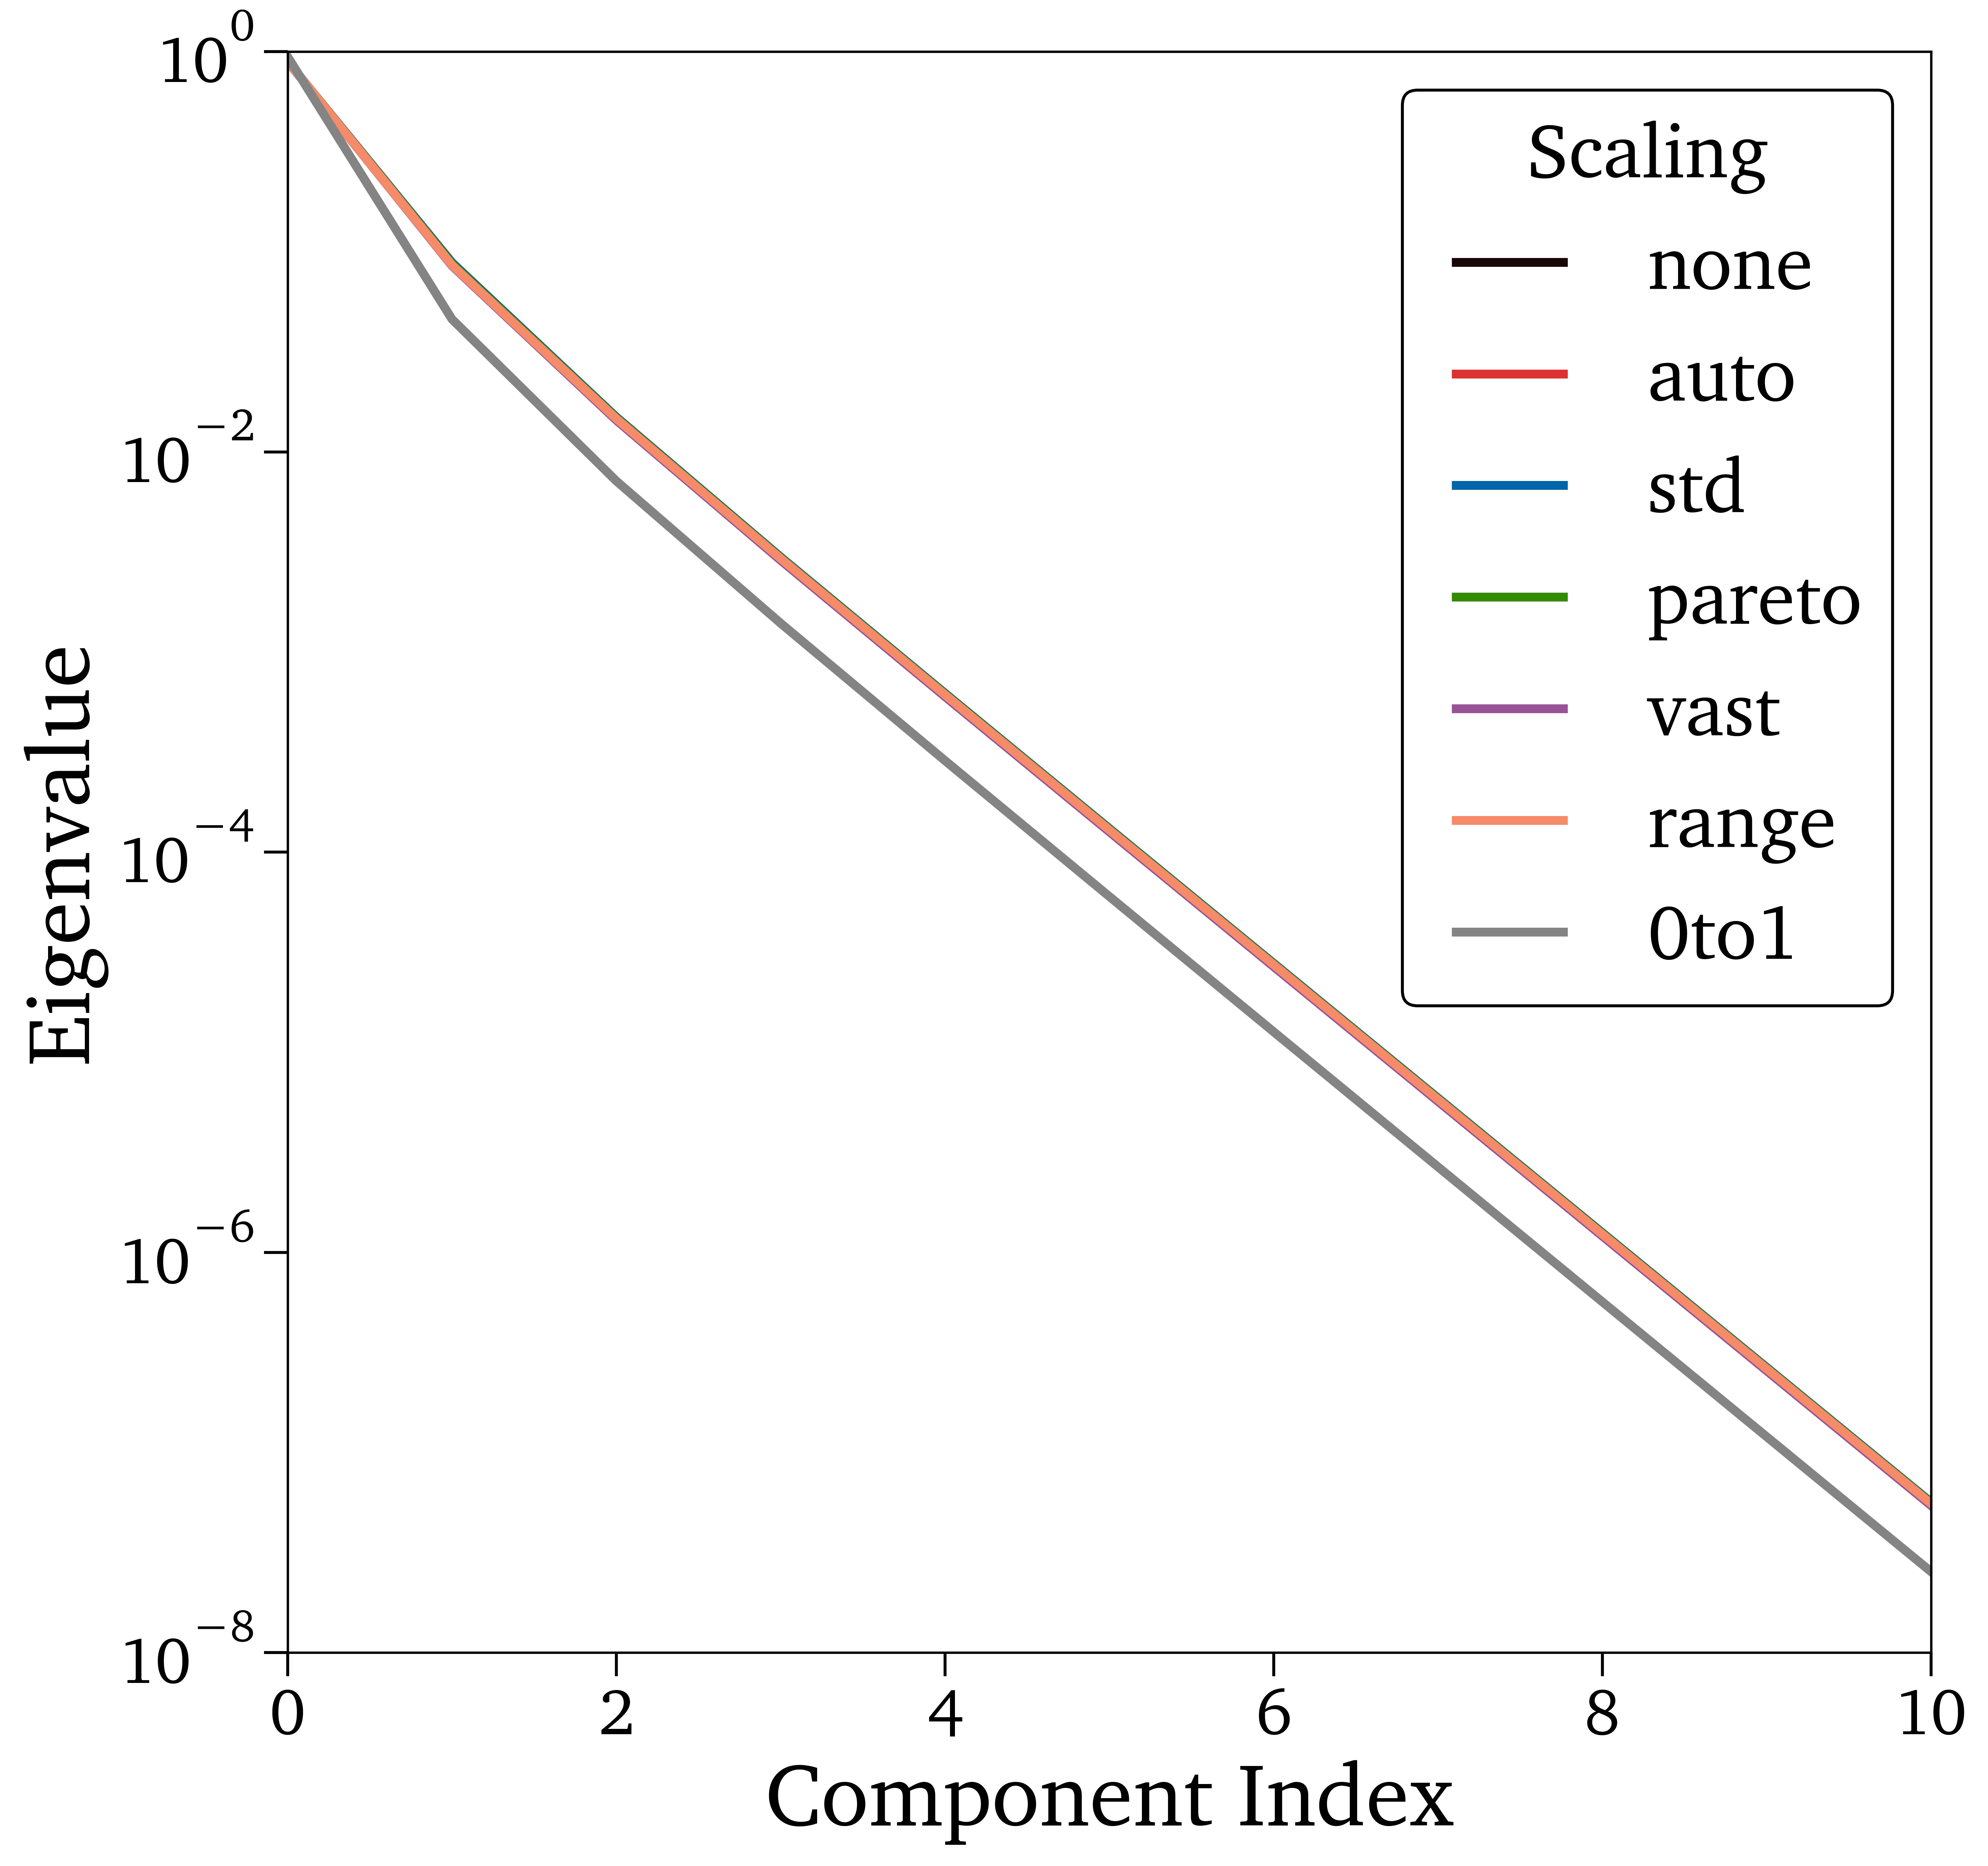

In [6]:
n_modes      = 64
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

plt.figure()
for j, Scaling in enumerate(ScalingVec):

    pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes))
    C          = pca.X_center
    D          = pca.X_scale
    A          = pca.A[:,0:n_modes].T
    L          = pca.L
    AT         = A.T

    plt.plot(L, label=Scaling)
    
plt.ylim([1.e-14, 1.e0])
plt.xlabel('Component Index')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend(title='Scaling')
plt.xlim([0,10])
plt.ylim([1.e-8,1.])

if (FigDir):
    plt.savefig(FigDir+'/TransTanh_Eigenvalues.eps', format='eps', bbox_inches='tight')

(1e-08, 0.1)

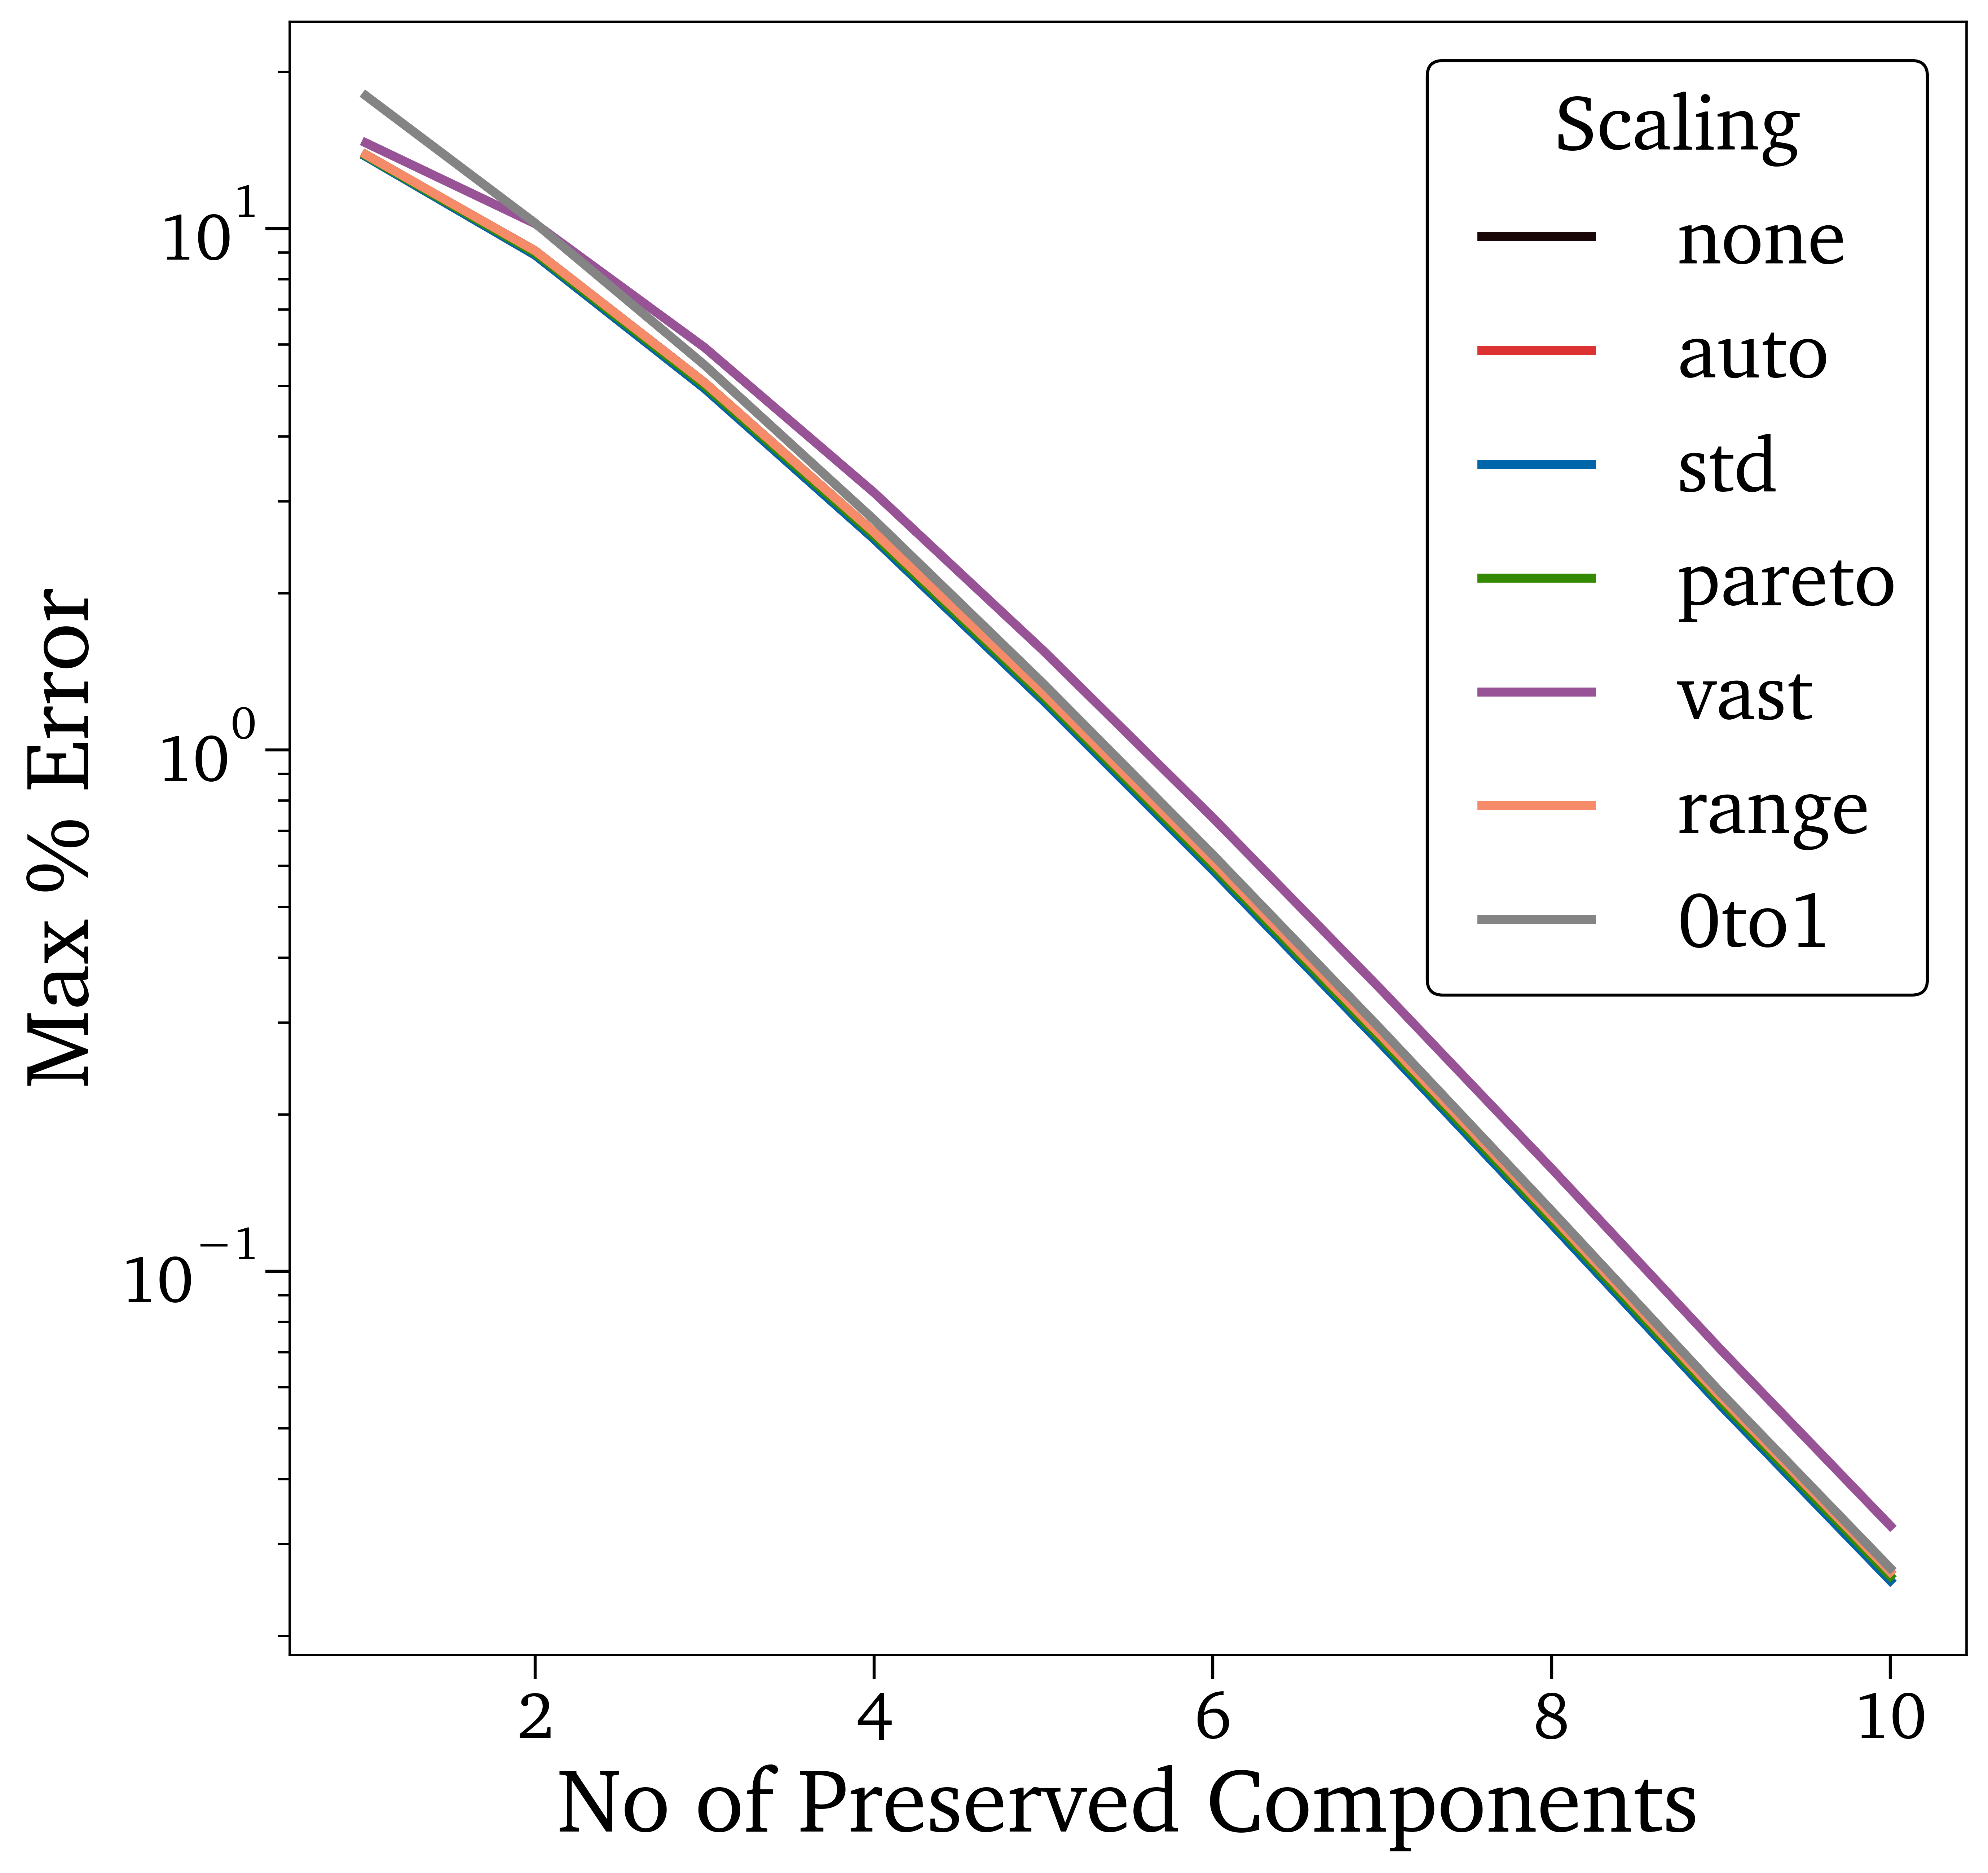

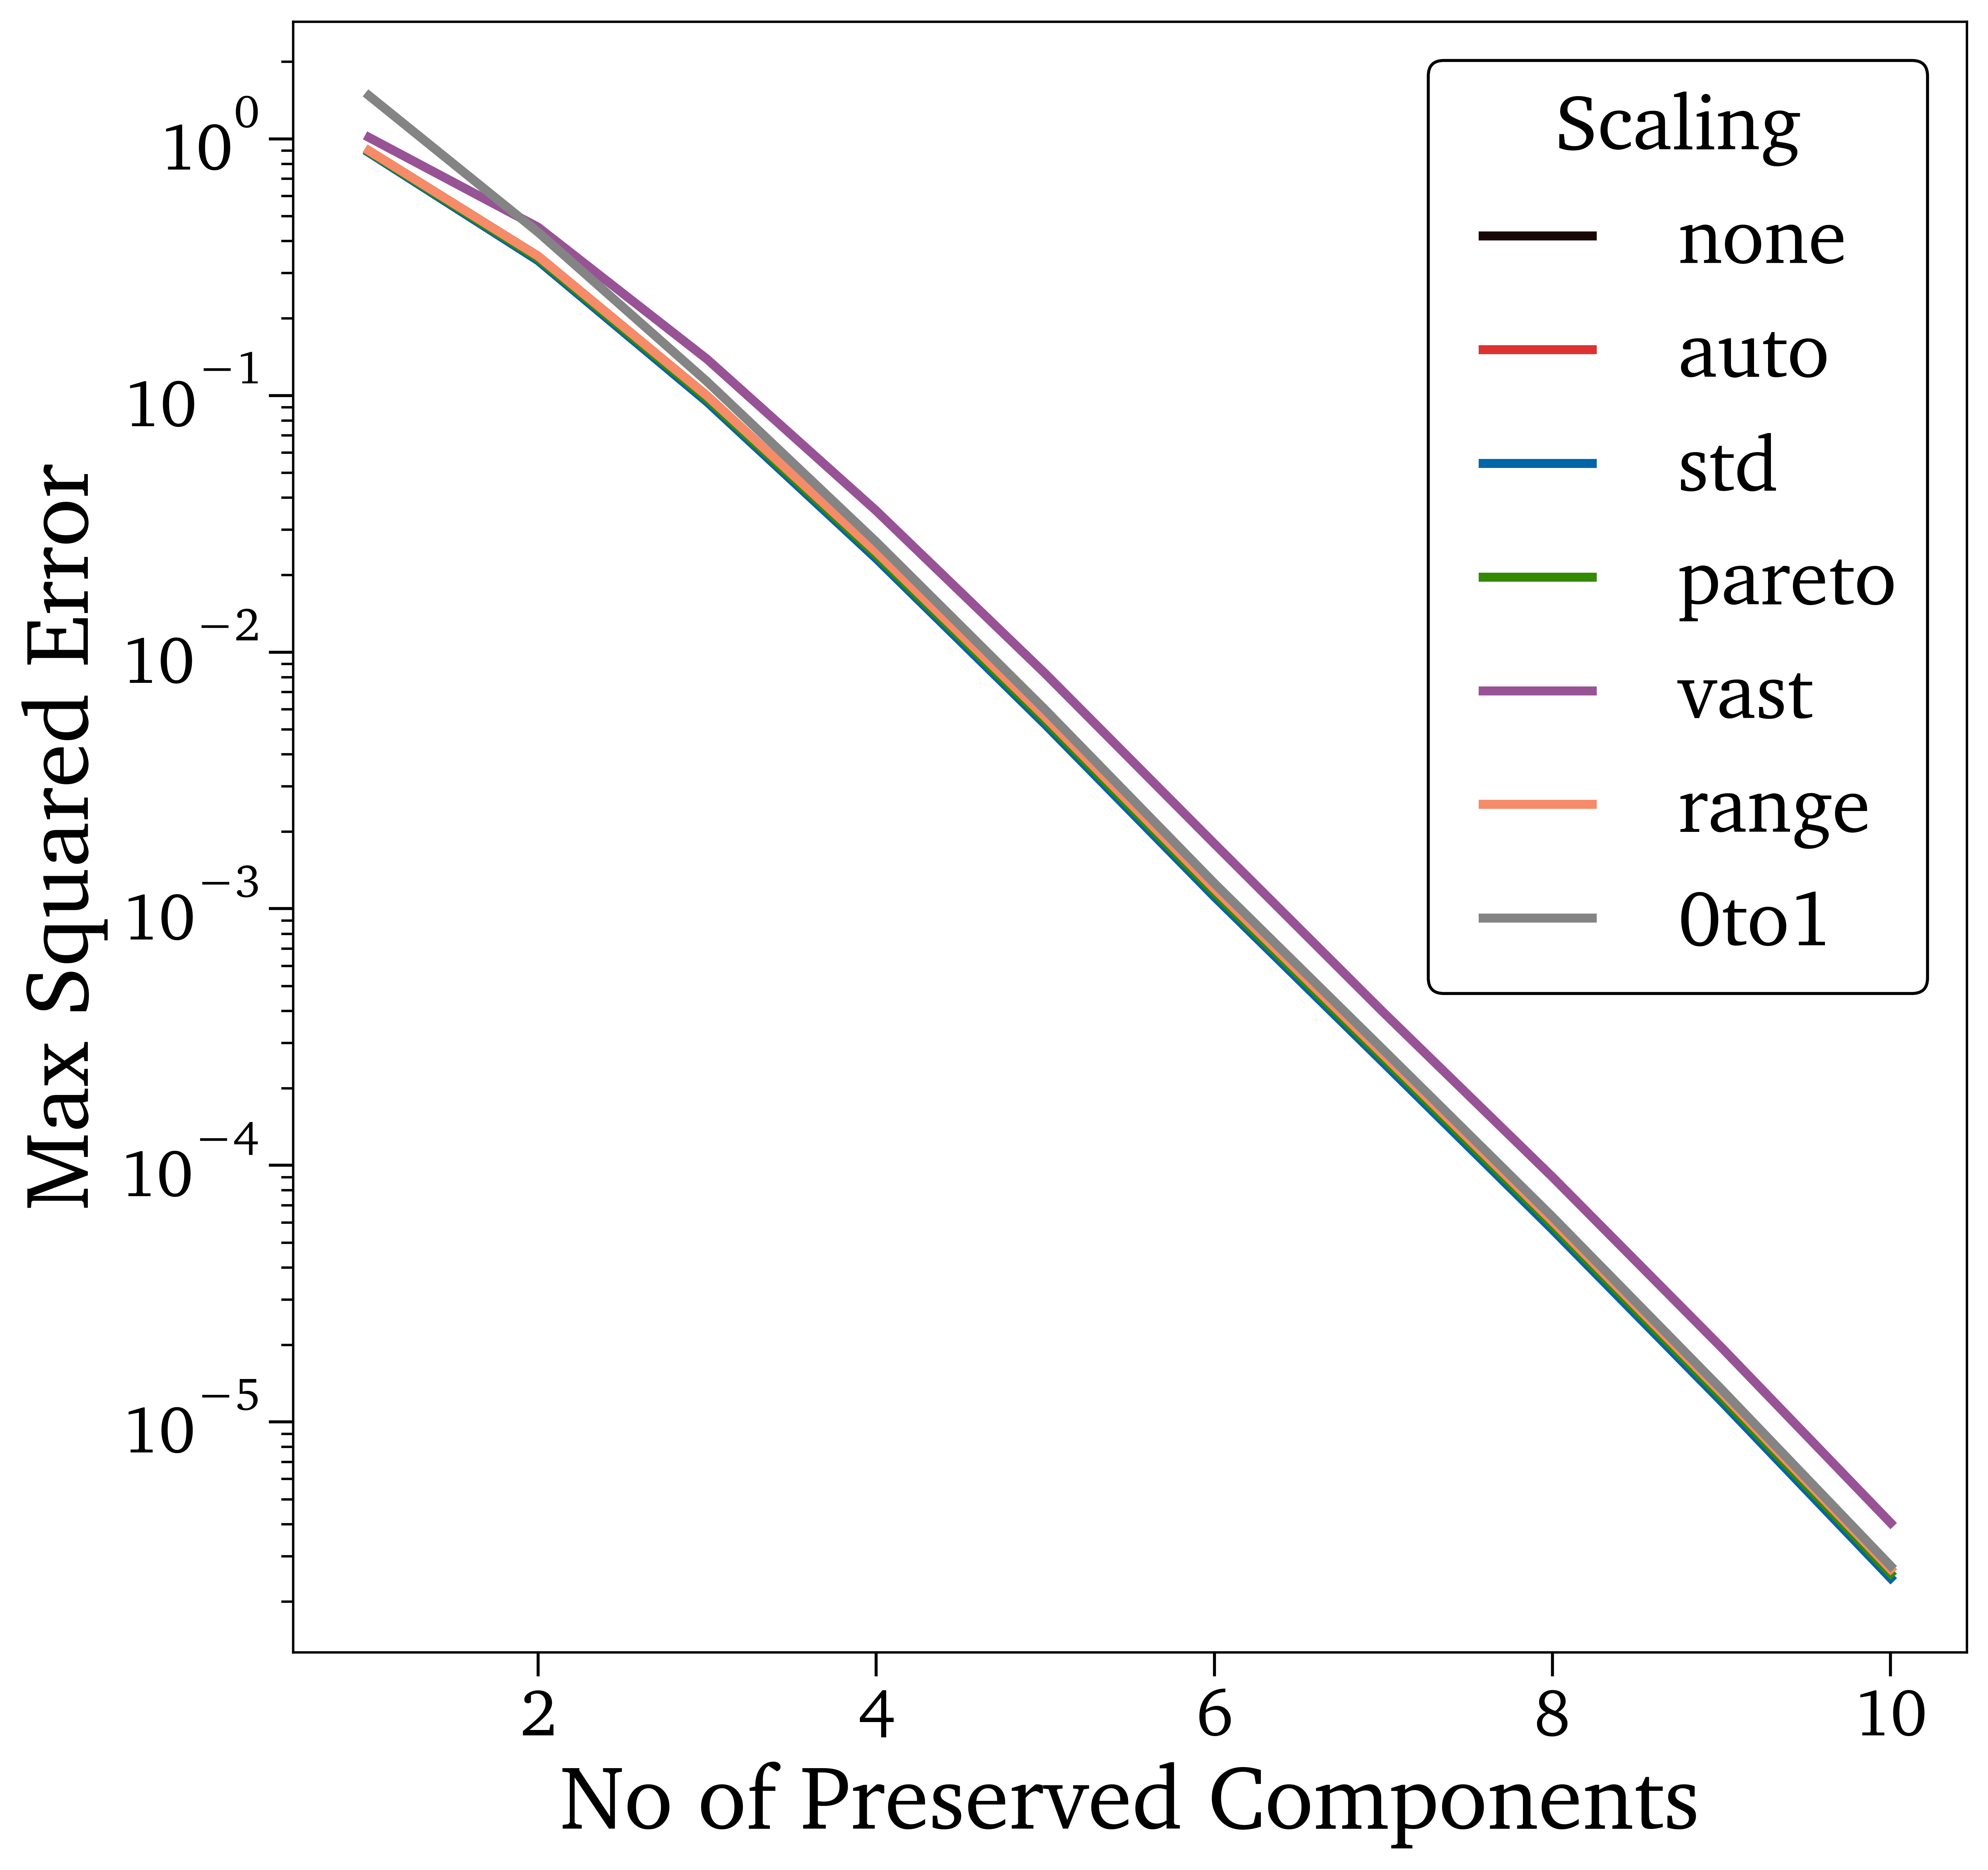

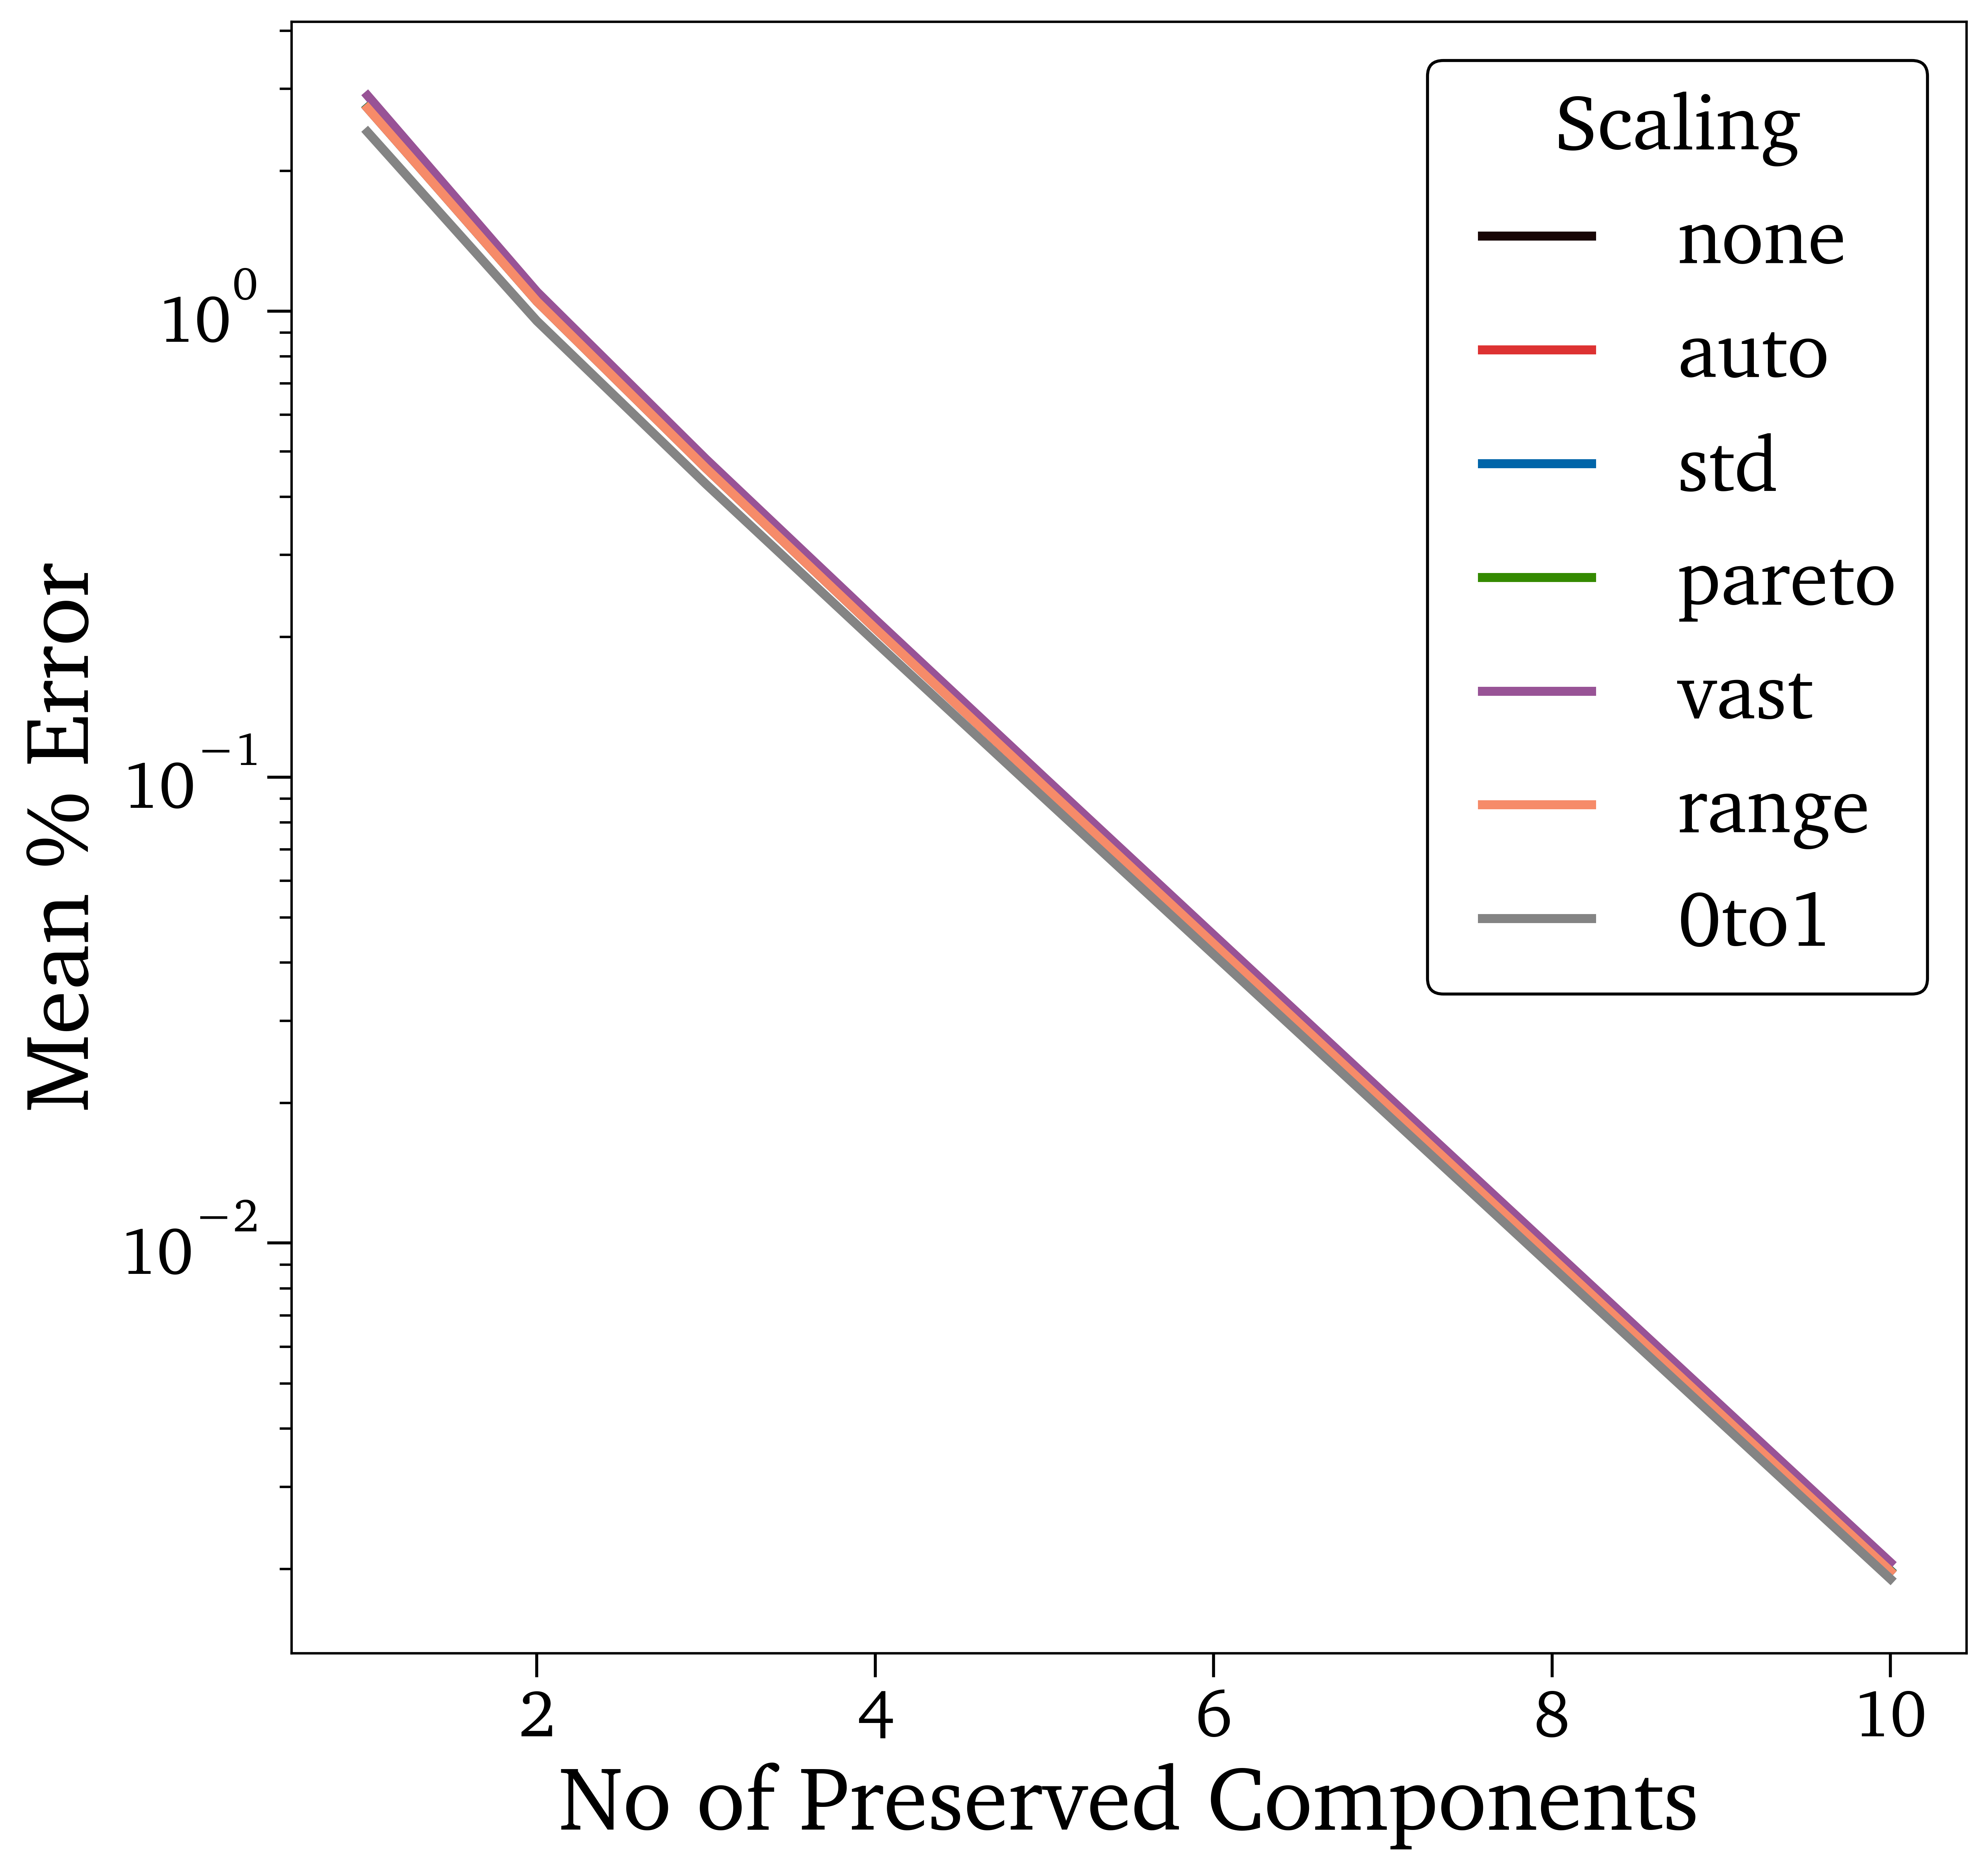

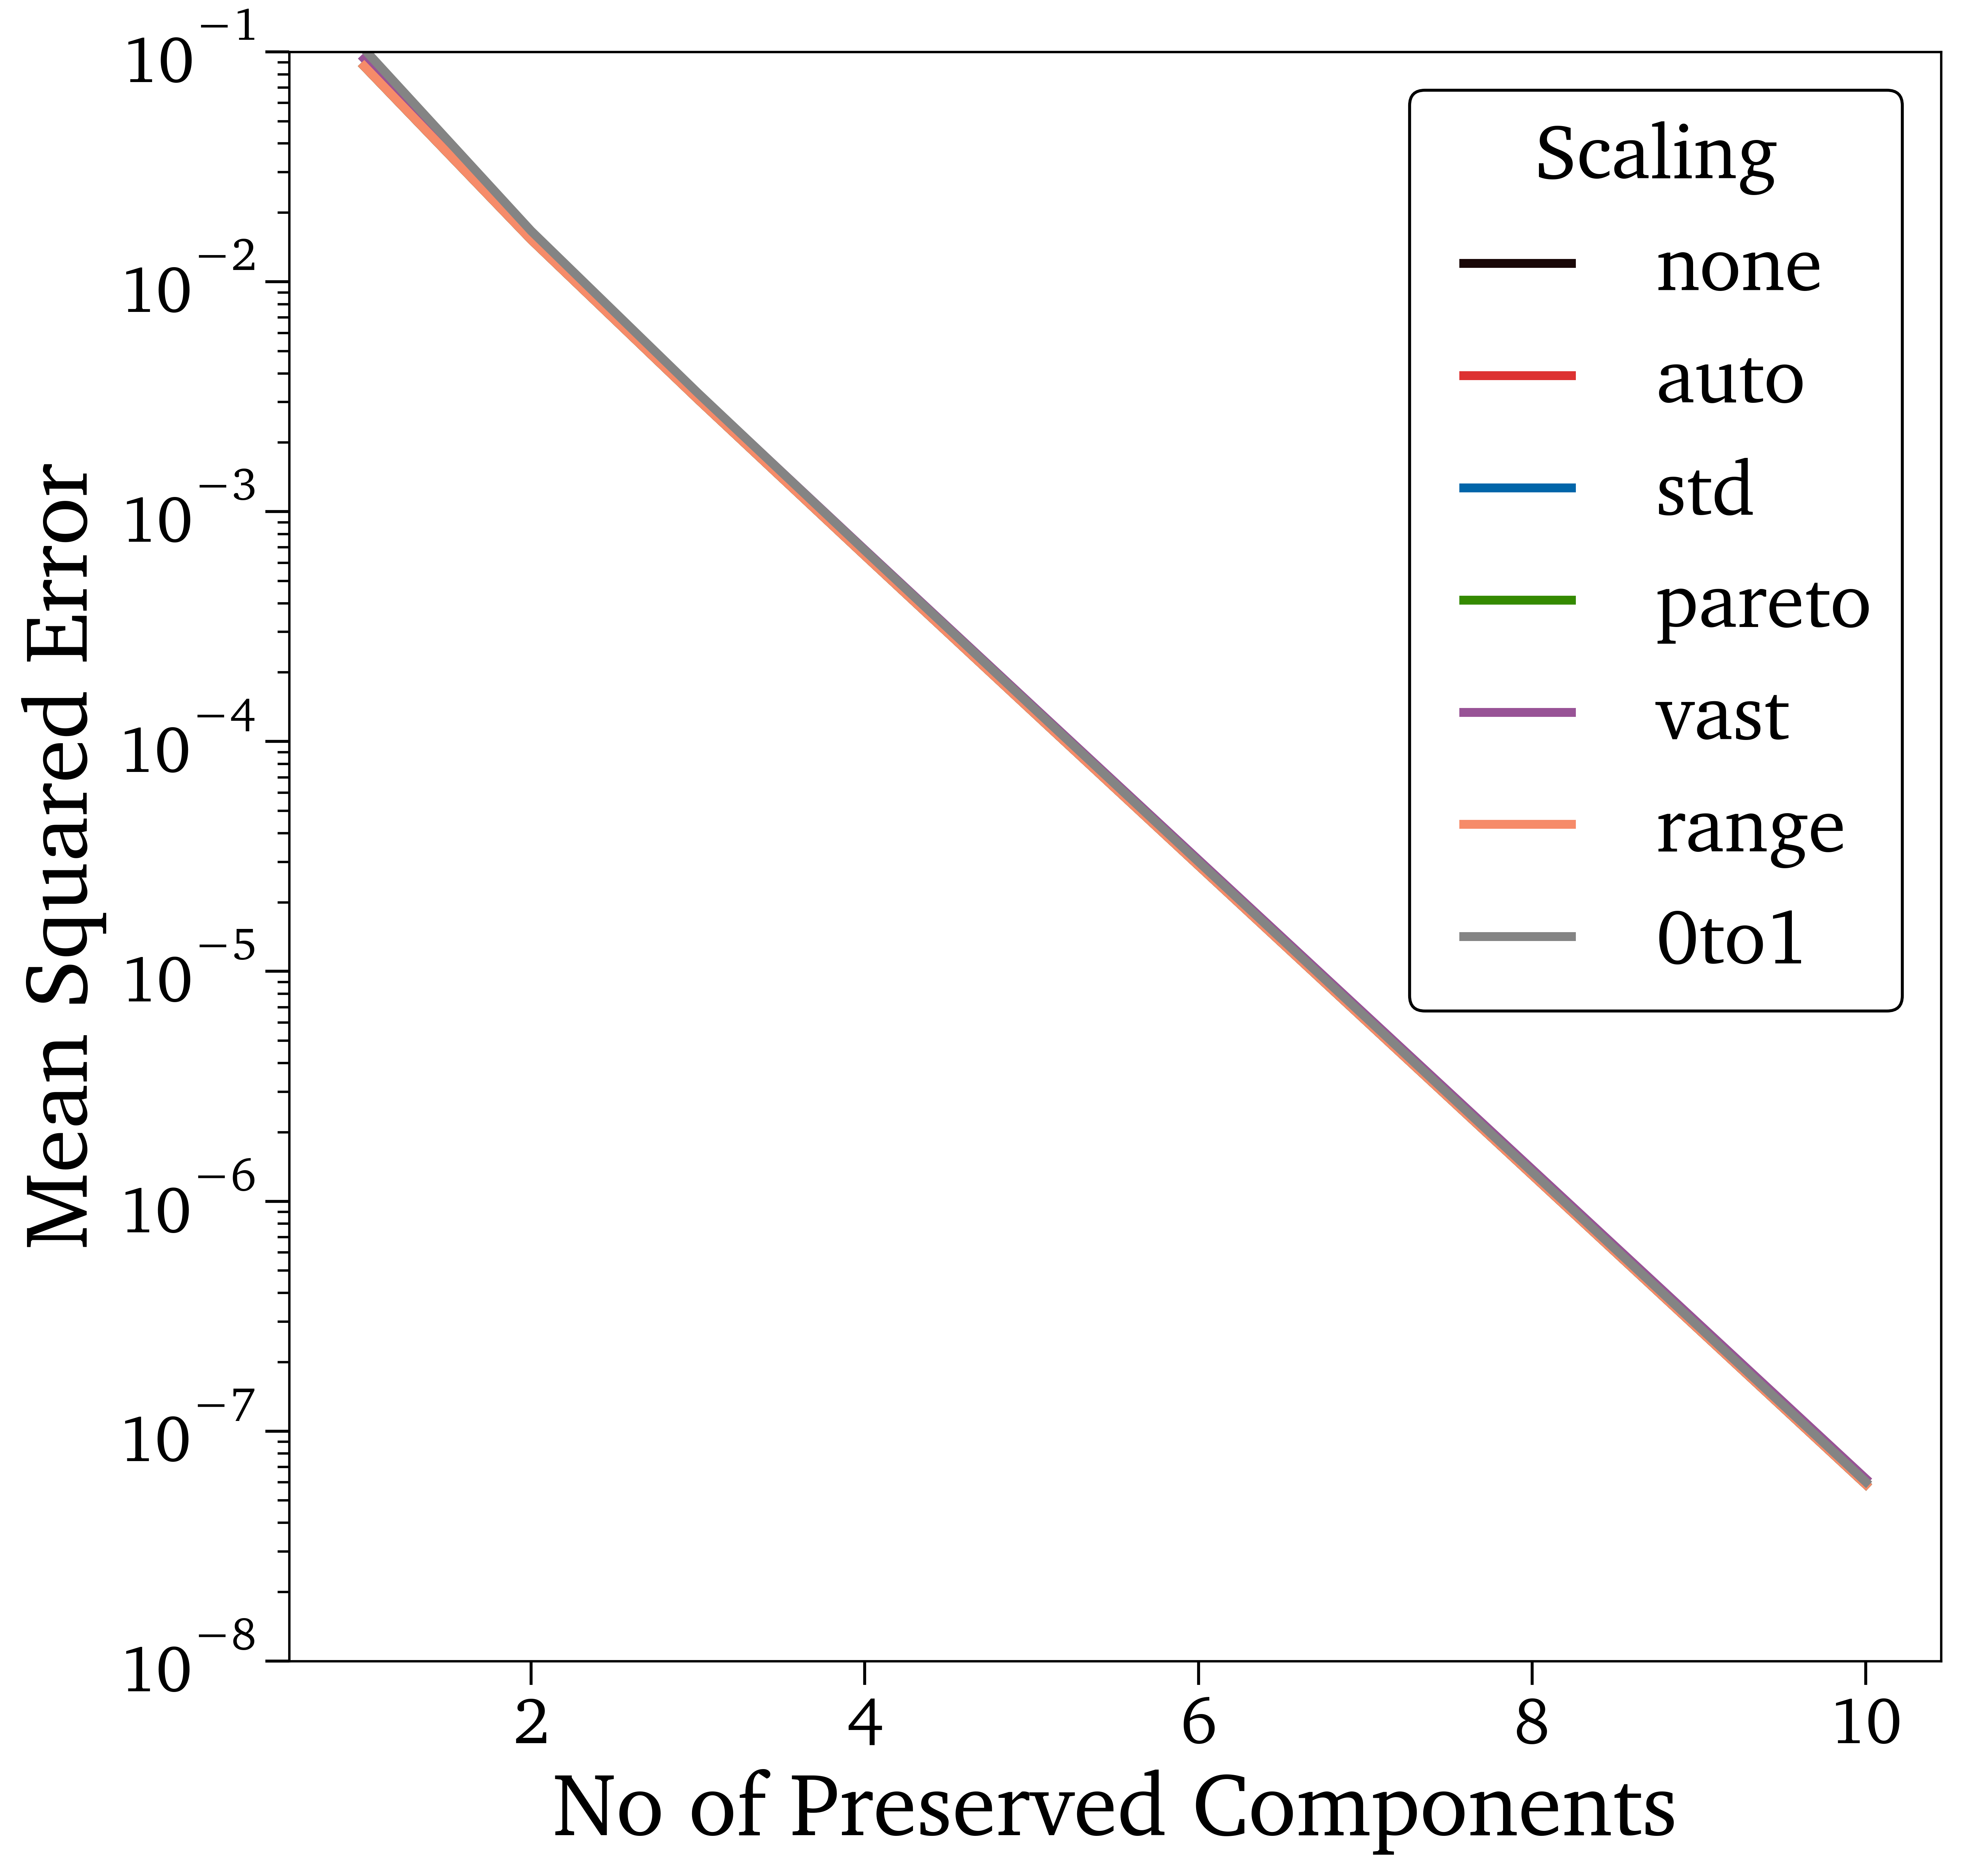

In [7]:
n_modesVec   = np.arange(1,11,1)
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

MaxPerc    = np.zeros((len(n_modesVec), len(ScalingVec)))
MaxSE      = np.zeros((len(n_modesVec), len(ScalingVec)))
MeanPerc   = np.zeros((len(n_modesVec), len(ScalingVec)))
MSE        = np.zeros((len(n_modesVec), len(ScalingVec)))
for i, n_modes in enumerate(n_modesVec):
    #print('n_modes = ', n_modes)
    
    for j, Scaling in enumerate(ScalingVec):

        pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes))
        C          = pca.X_center
        D          = pca.X_scale
        A          = pca.A[:,0:n_modes].T
        L          = pca.L
        AT         = A.T

        yMat_pca   = ((yMat - C)/D).dot(AT)
        yMat_      = (yMat_pca.dot(A))*D + C
        
        MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
        MaxSE[i,j]      = np.max((yMat - yMat_)**2)
        MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
        MSE[i,j]        = np.mean((yMat - yMat_)**2)

plt.figure()
plt.plot(n_modesVec, MaxPerc, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Max % Error')
plt.legend(title='Scaling')
plt.yscale('log')

plt.figure()
plt.plot(n_modesVec, MaxSE, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Max Squared Error')
plt.legend(title='Scaling')
plt.yscale('log')

plt.figure()
plt.plot(n_modesVec, MeanPerc, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Mean % Error')
plt.legend(title='Scaling')
plt.yscale('log')

plt.figure()
plt.plot(n_modesVec, MSE, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Mean Squared Error')
plt.legend(title='Scaling')
plt.yscale('log')
plt.ylim([1e-8, 1e-1])

## Preserving the first $n_{modesFinal}$ Singular Values and Saving the Related Matrixes/Vectors

In [8]:
pca        = PCAA(yMat, scaling='none', n_components=2, nocenter=True)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:2].T
L          = pca.L
AT         = A.T
yMat_Scaled= ((yMat - C)/D)
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (2, 100)
[PCA] 


In [9]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca_2 = ((yMat - C)/D).dot(AT)

yMat_2_    = (yMat_pca_2.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_2_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_2_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_2_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_2_)**2))

[PCA] Shape of yMat_pca =  (500, 10)
[PCA]  Max % Error =  10.39815152715609
[PCA]  Max      SE =  0.4621635721303988
[PCA] Mean % Error =  0.9705534318372423
[PCA]          MSE =  0.017503008617427637


In [10]:
pca        = PCAA(yMat, scaling='none', n_components=n_modesFinal, nocenter=True)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:n_modesFinal].T
L          = pca.L
AT         = A.T
yMat_Scaled= ((yMat - C)/D)
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (8, 100)
[PCA] 


### Reduction Error Estimate

In [11]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (500, 8)
[PCA]  Max % Error =  0.13613006201533778
[PCA]  Max      SE =  7.260010194400978e-05
[PCA] Mean % Error =  0.00899571635538396
[PCA]          MSE =  1.3595419327979962e-06


### Plotting the Components of the Projection Matrix

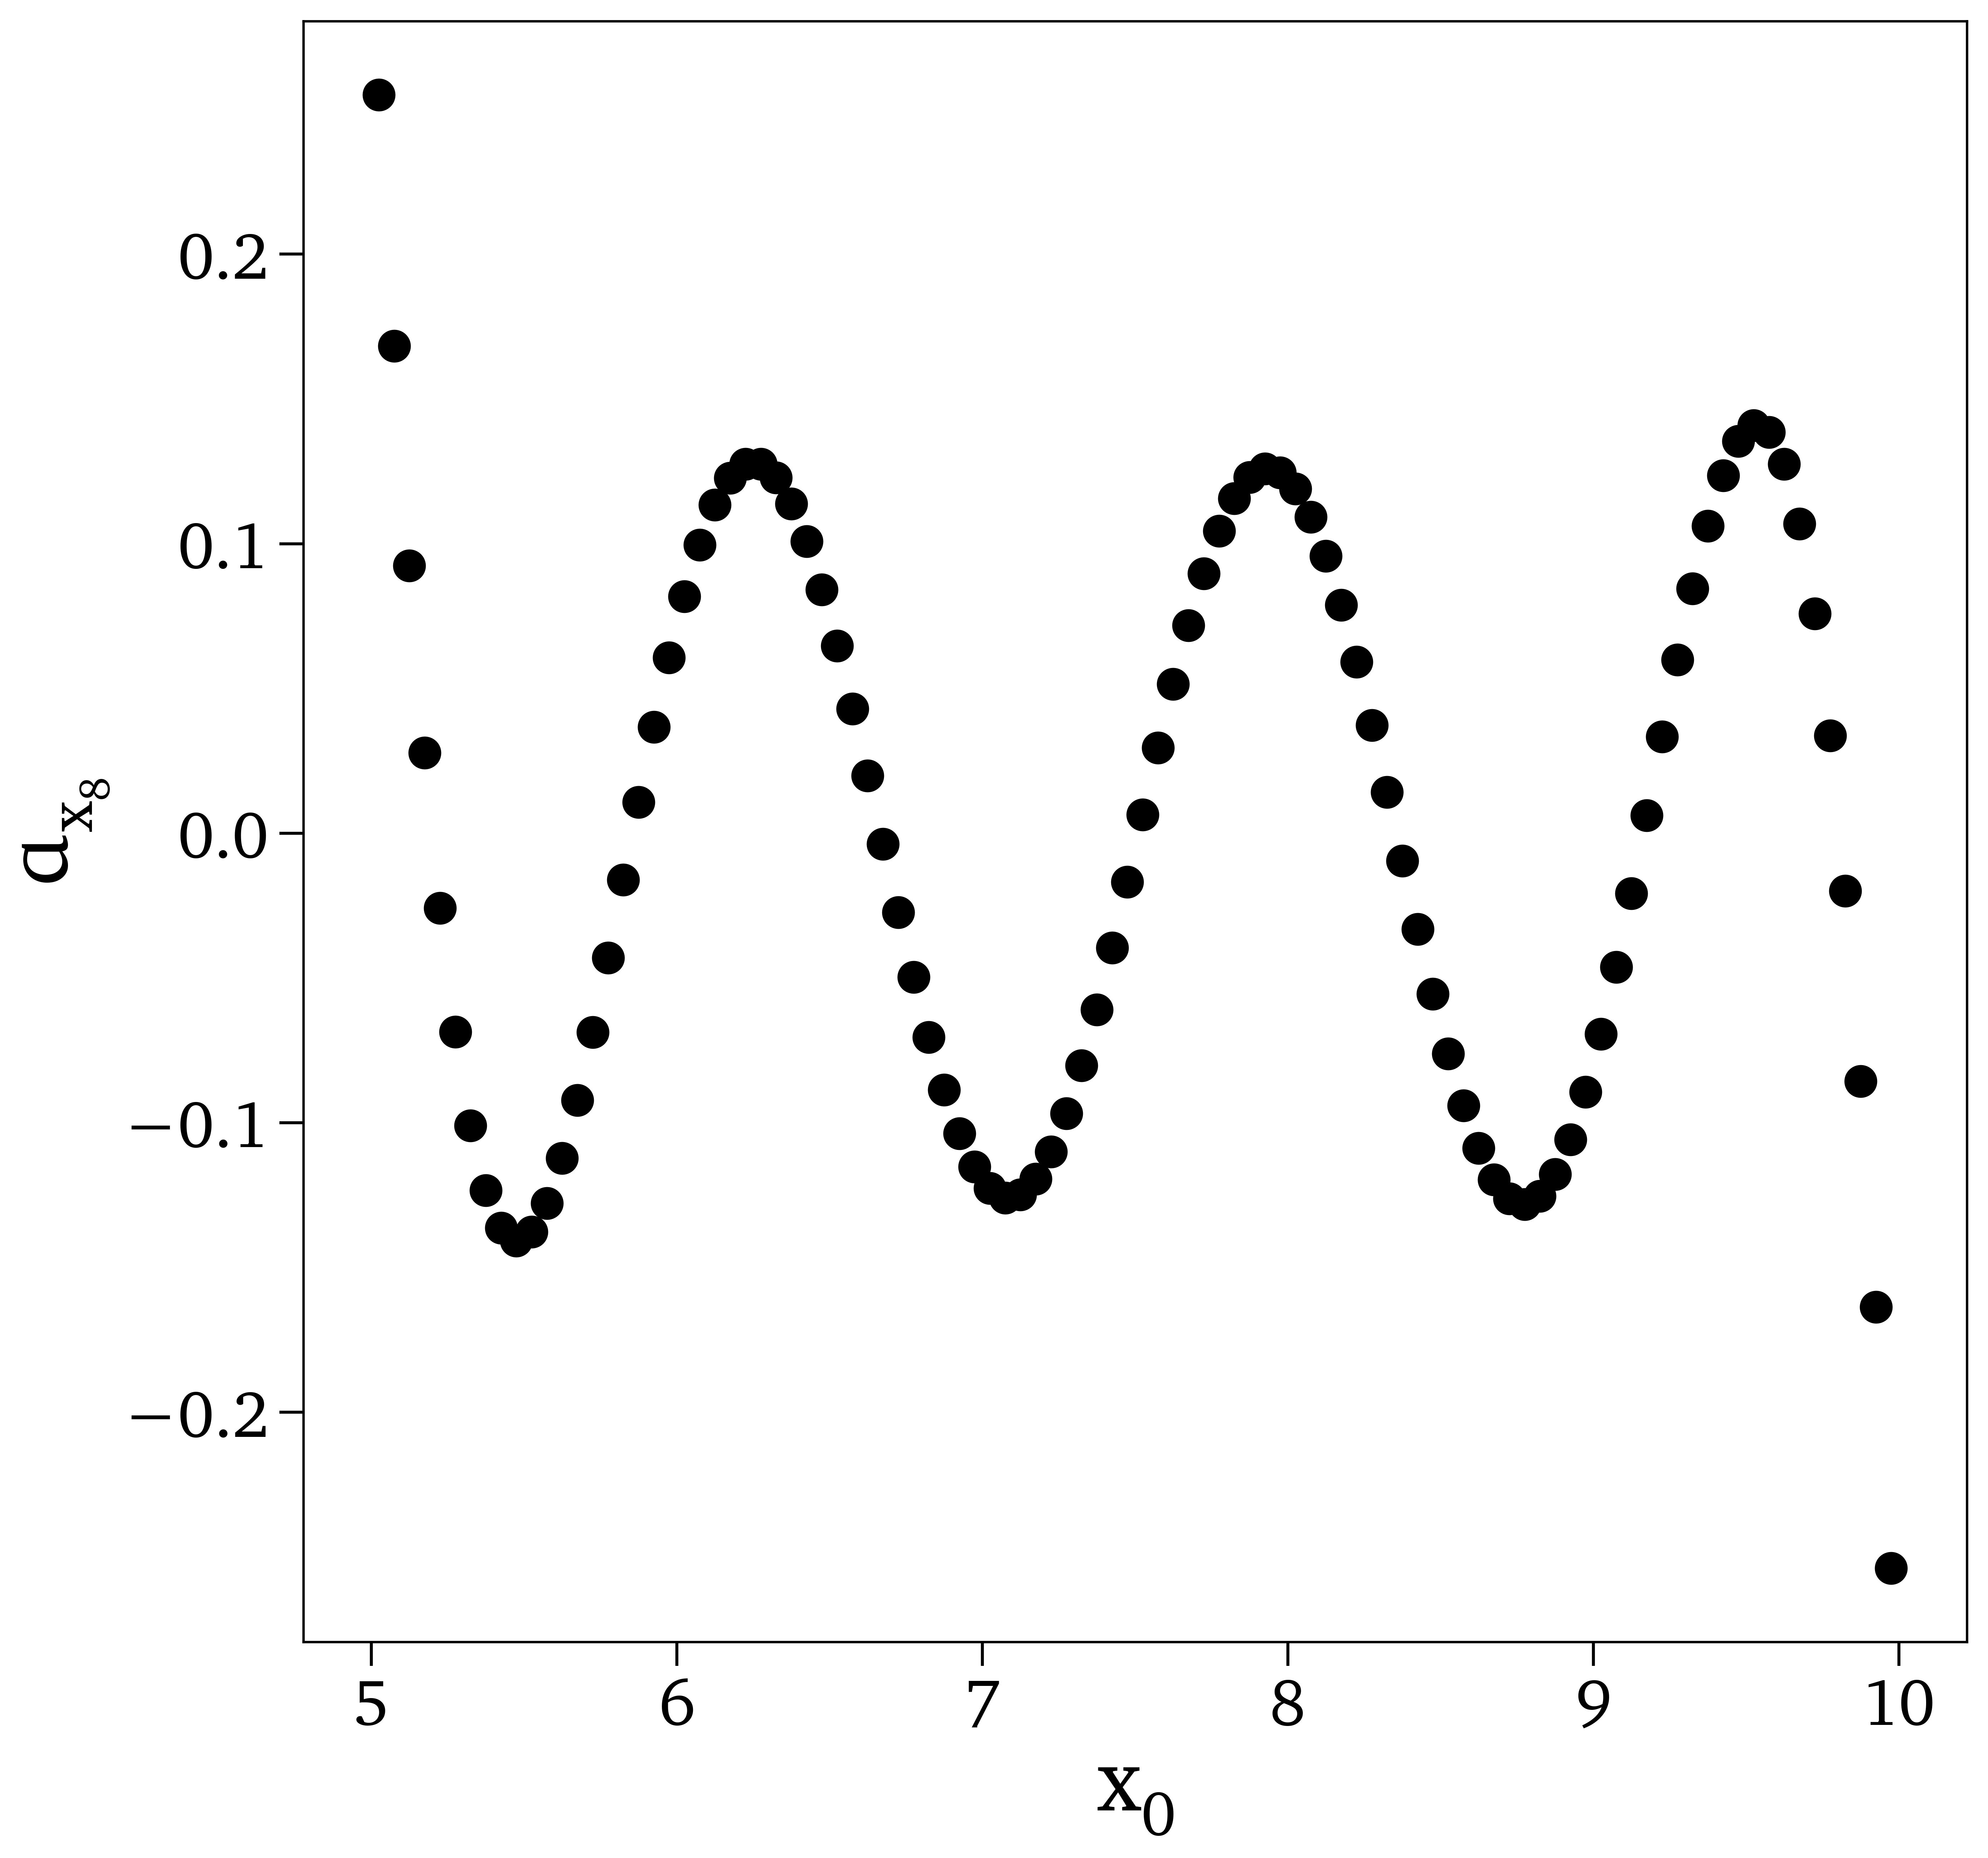

In [12]:
# %matplotlib qt

iVar    = n_modesFinal-1

fig = plt.figure(figsize=(10,10))
plt.scatter(ICs[:,0], A[iVar,:], c='k')
plt.xlabel(r'$x_{0}$')
plt.ylabel(r'$\alpha_{x_'+str(iVar+1)+'}$')

if (FigDir):
    plt.savefig(FigDir+'/TransTanh_Alpha'+str(iVar+1)+'.eps', format='eps', bbox_inches='tight')

### Plotting Eigenmodes

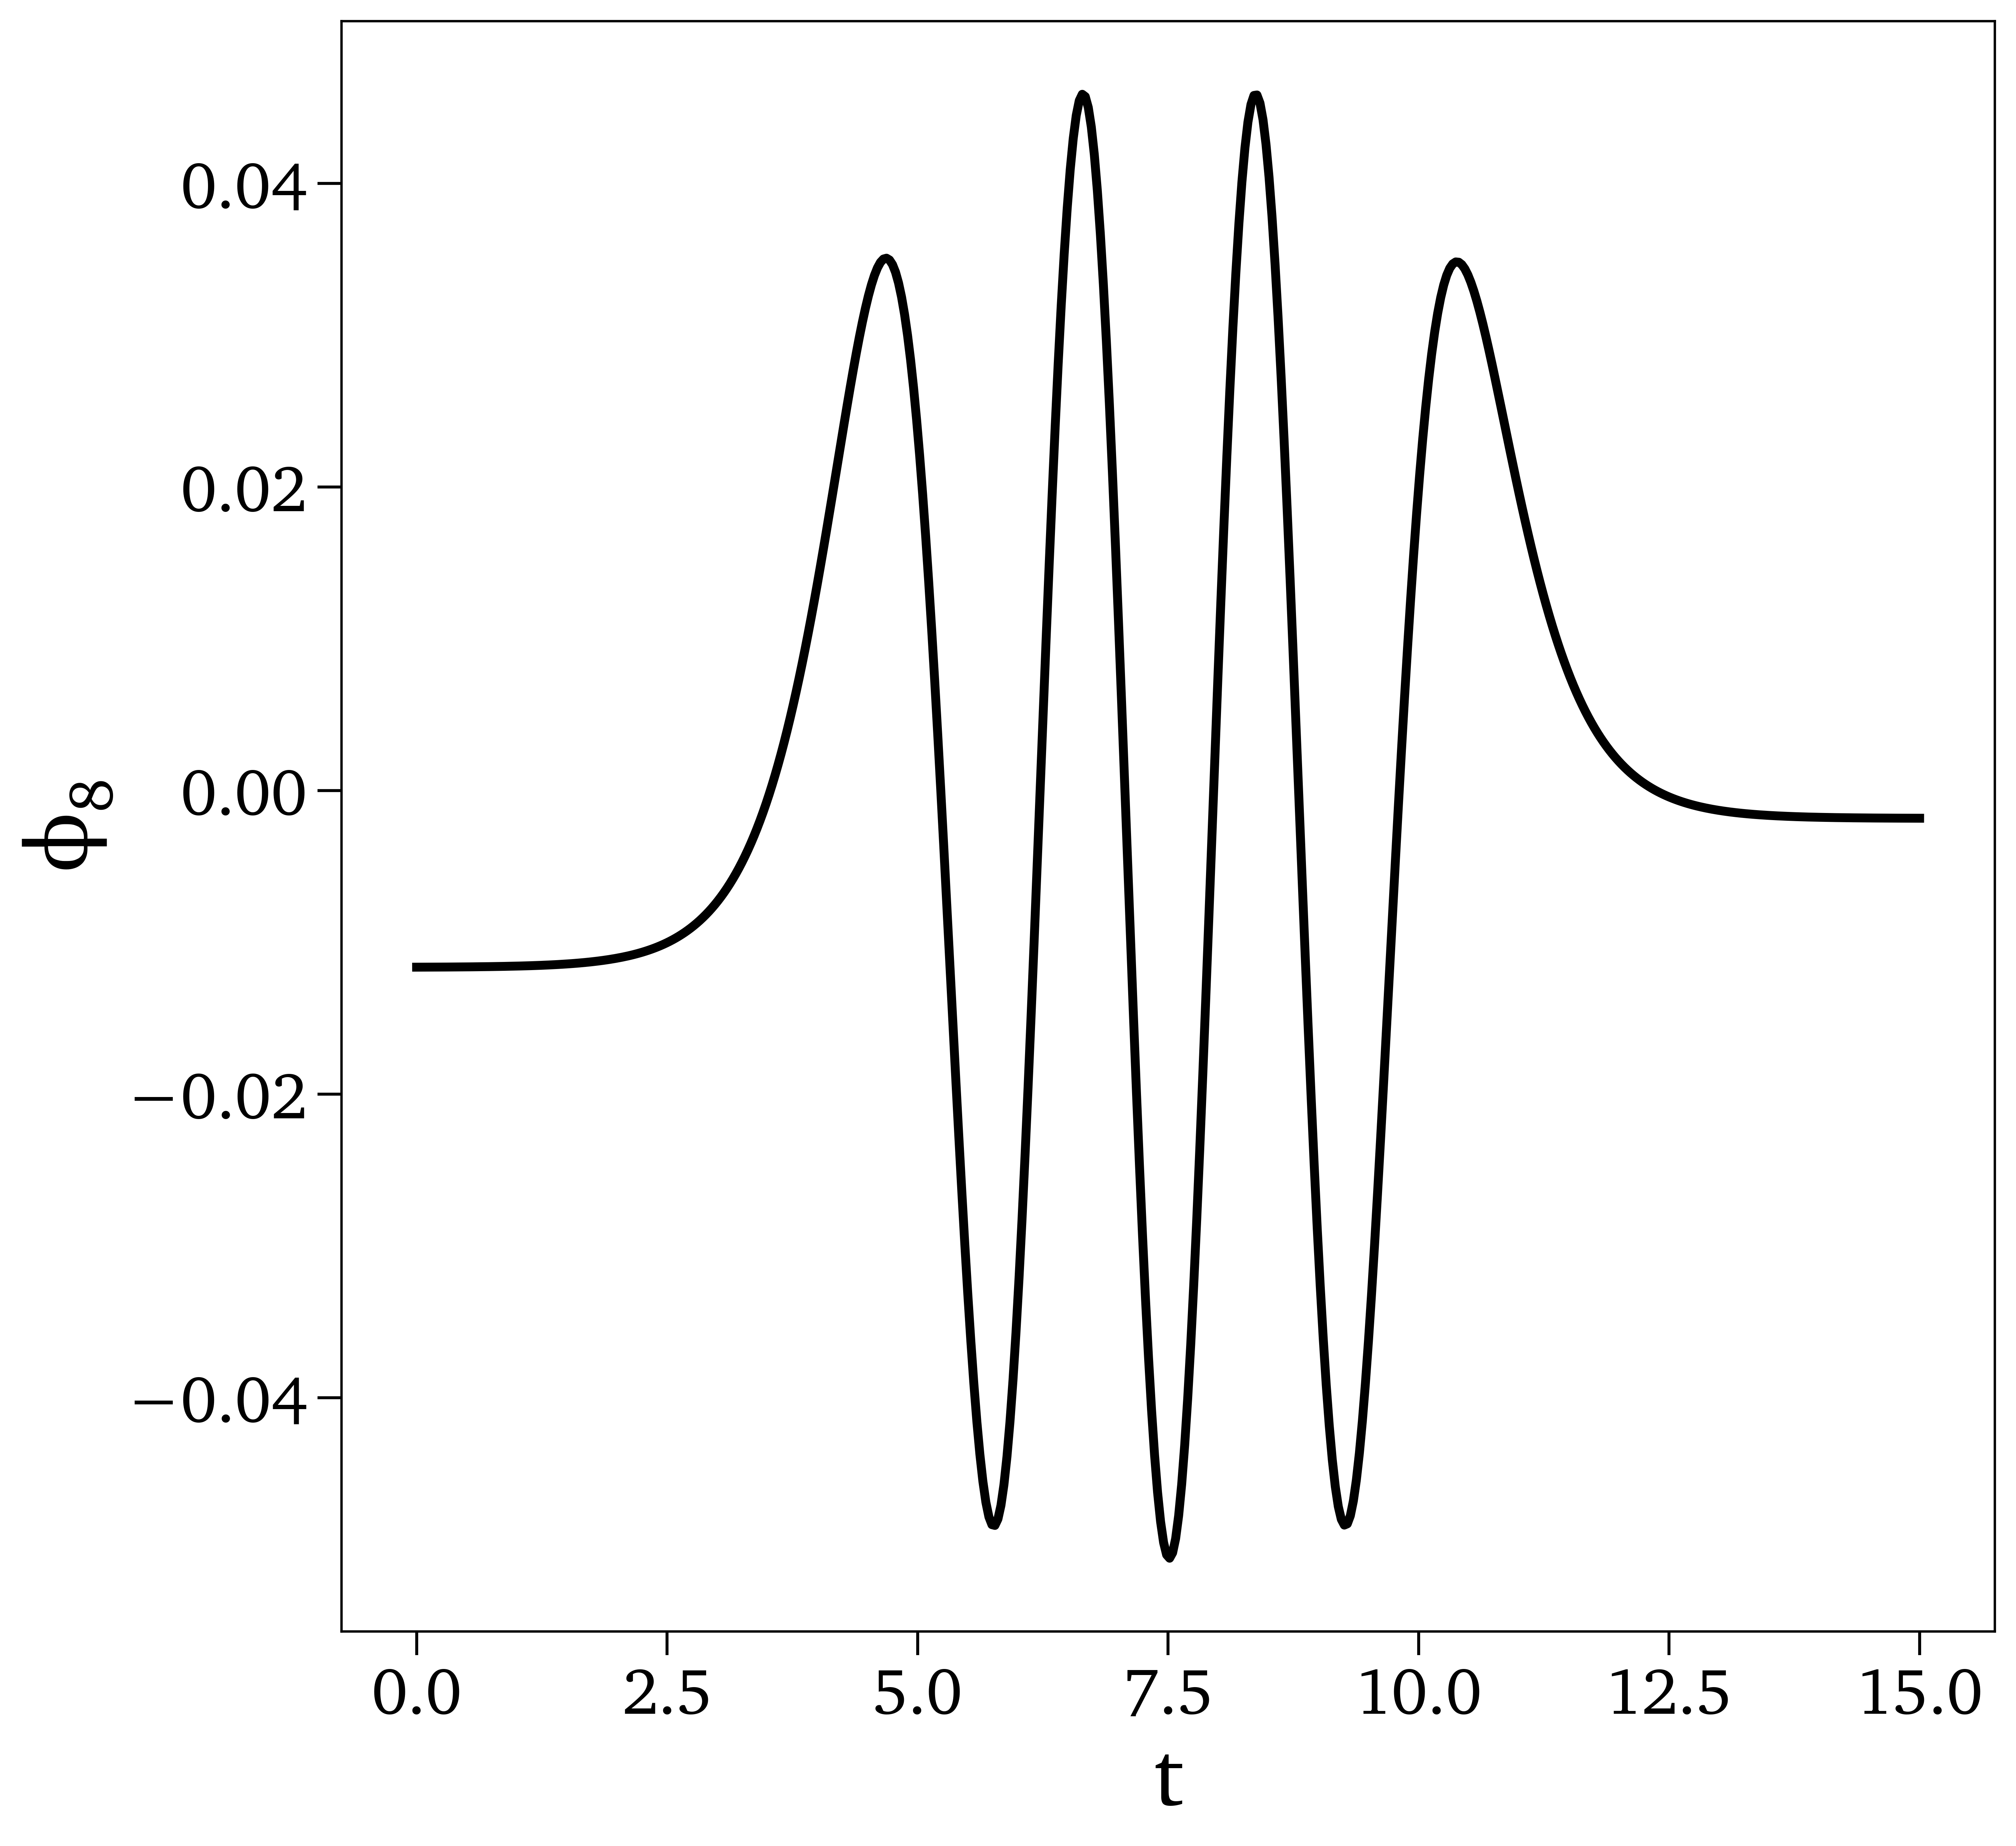

In [13]:
iVar = 7#n_modesFinal-1

plt.figure()
plt.plot(tVec, yMat_pca[:,iVar], '-k')
plt.xlabel('t')
plt.ylabel(r'$\phi_{'+str(iVar+1)+'}$')

if (FigDir):
    plt.savefig(FigDir+'/TransTanh_phi'+str(iVar+1)+'.eps', format='eps', bbox_inches='tight')

### Comparing Original Data vs Encoded-Decoded Data

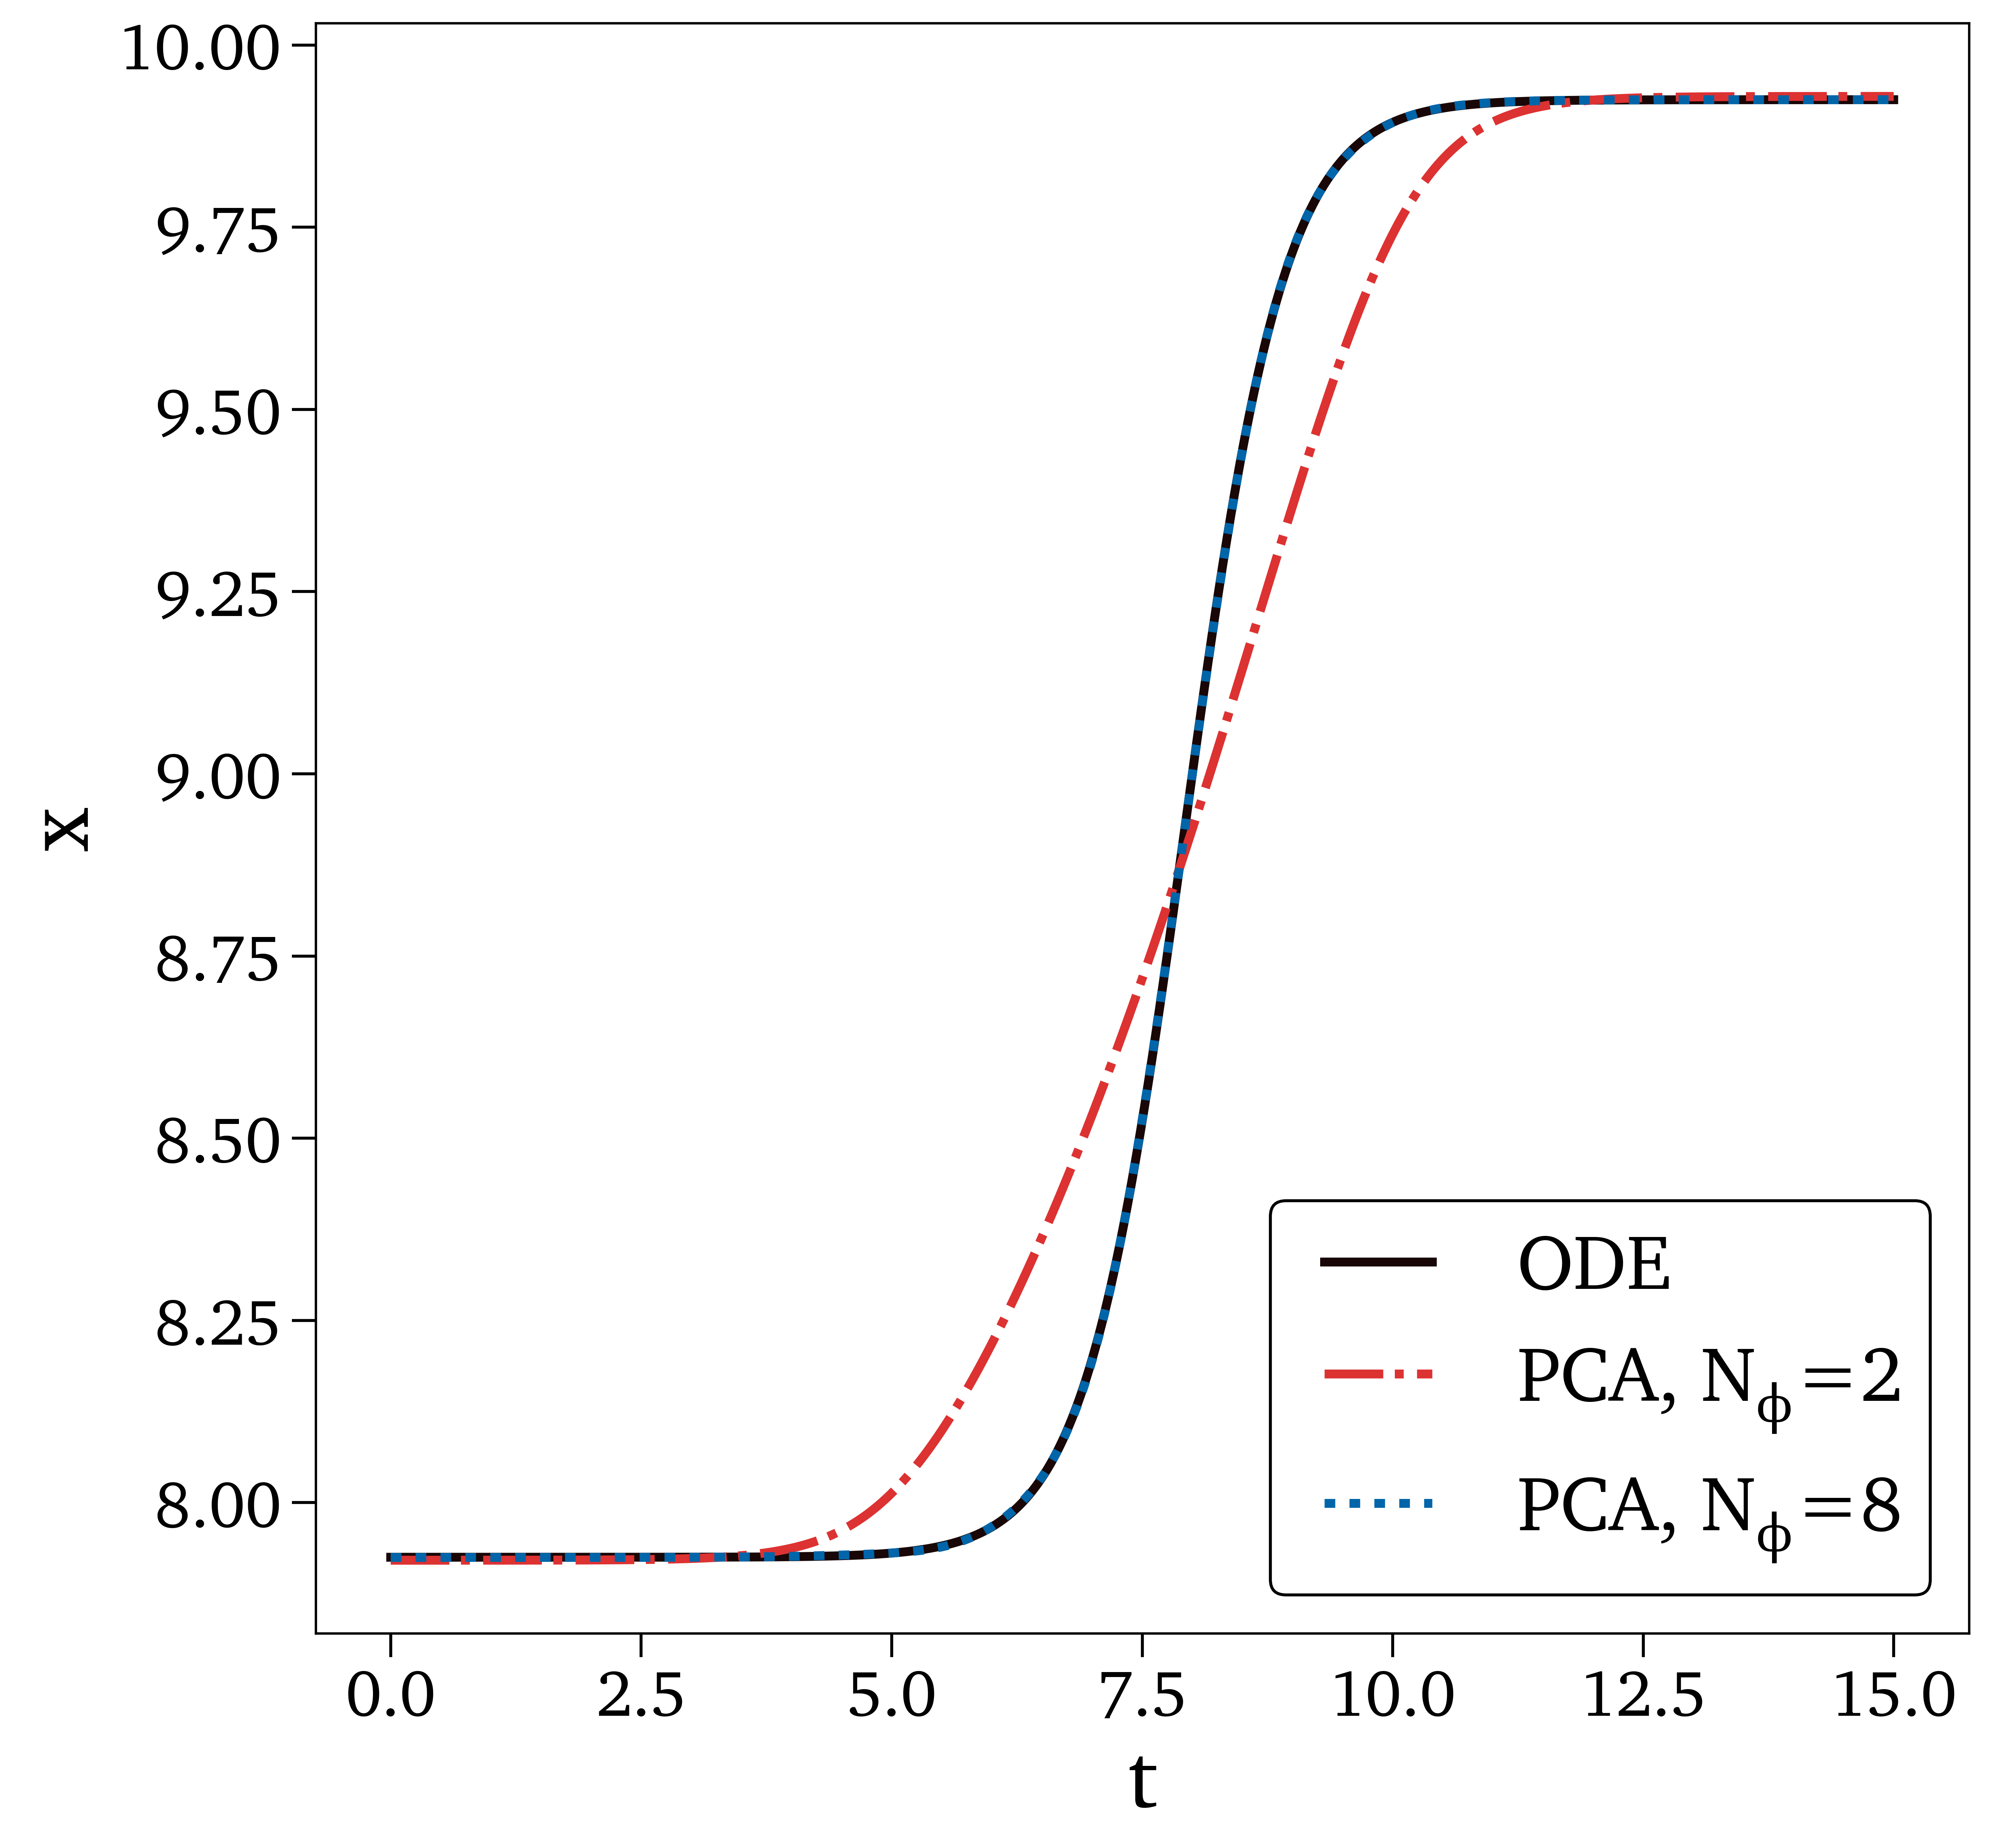

In [14]:
plt.figure()
plt.plot(tVec, yMat[:,7],     '-', label='ODE')
plt.plot(tVec, yMat_2_[:,7], '-.', label='PCA, $N_{\phi}$=2')
plt.plot(tVec, yMat_[:,7],    ':', label='PCA, $N_{\phi}$=8')
plt.legend(loc=4)
plt.xlabel('t')
plt.ylabel('x')

if (FigDir):
    plt.savefig(FigDir+'/TransTanh_PCAReconstructed.eps', format='eps', bbox_inches='tight')

## Writing Training and Test Data for the Trunks' and Brunches' FNNs

In [15]:
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

FileName    = OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/ROM/yMat_Scaled.csv'
np.savetxt(FileName, yMat_Scaled, delimiter=',')

In [16]:
VarsPCA          = ['PCA_'+str(i_mode+1) for i_mode in range(n_modesFinal)]
Data             = pd.DataFrame(yMat_pca, columns=VarsPCA)
#tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0    76.297911 -3.428512 -0.238193 -0.352264  0.042189  0.061198  0.008690   
1    76.297916 -3.428505 -0.238187 -0.352259  0.042185  0.061196  0.008689   
2    76.297920 -3.428497 -0.238180 -0.352254  0.042182  0.061193  0.008688   
3    76.297925 -3.428488 -0.238172 -0.352248  0.042178  0.061191  0.008686   
4    76.297931 -3.428479 -0.238164 -0.352242  0.042175  0.061189  0.008685   
..         ...       ...       ...       ...       ...       ...       ...   
495  96.088221 -0.567994  0.008751 -0.056912  0.000217  0.009710  0.000255   
496  96.088229 -0.568002  0.008758 -0.056917  0.000214  0.009712  0.000253   
497  96.088237 -0.568010  0.008765 -0.056922  0.000211  0.009714  0.000252   
498  96.088244 -0.568017  0.008771 -0.056927  0.000208  0.009716  0.000251   
499  96.088251 -0.568024  0.008776 -0.056931  0.000205  0.009718  0.000250   

        PCA_8         t    log(t)  log10(t)  
0   -0.011635   0.00000      -inf      -inf  
1   -0.011634   0.03006 -3.504556 -1.522009  
2   -0.011634   0.06012 -2.811409 -1.220979  
3   -0.011633   0.09018 -2.405944 -1.044888  
4   -0.011632   0.12024 -2.118262 -0.919949  
..        ...       ...       ...       ...  
495 -0.001819  14.87976  2.700002  1.172596  
496 -0.001819  14.90982  2.702020  1.173472  
497 -0.001820  14.93988  2.704034  1.174347  
498 -0.001821  14.96994  2.706044  1.175220  
499 -0.001821  15.00000  2.708050  1.176091  

[500 rows x 11 columns]

### Trunks

In [17]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/test/')
except:
    pass

In [18]:
data_id    = 'pts'

DataNoZero           = Data#[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPCA]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPCA]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [19]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points


try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPCA]
DataInput.to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPCA]
DataOutput.to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Trunk/test/ext/Output.csv', index=False)

### Branches

In [20]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name)
except:
    pass

In [21]:
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/test/')
except:
    pass

In [22]:
data_id    = 'pts'

n_points             = len(DataIC)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/valid/'+data_id+'/')
except:
    pass

DataInput  = DataIC
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/valid/'+data_id+'/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['PCA_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/valid/'+data_id+'/Output.csv', index=False)

In [23]:
n_points             = len(DataIC)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/test/ext/')
except:
    pass

DataInput  = DataIC
DataInput.to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/test/ext/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['PCA_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch/test/ext/Output.csv', index=False)

In [24]:
### EXPERIMENTING

# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/train/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/valid/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/test/')
# except:
#     pass

In [25]:
# data_id    = 'pts'

# n_points             = len(DataIC)


# # idx                  = np.arange(n_points)
# # train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)
# idx                  = np.arange(n_points)
# train_idx            = idx
# valid_idx            = idx

# n_valid              = len(valid_idx)
# n_train              = len(train_idx)

# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/valid/'+data_id+'/')
# except:
#     pass

# DataInput  = DataIC
# DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/valid/'+data_id+'/Input.csv', index=False)

# YY = np.zeros((A.shape[1],A.shape[1]), dtype=int)
# for i in range(YY.shape[0]):
#     YY[i,i] = 1
# DataYY = pd.DataFrame(YY, columns=['IC_'+str(i+1) for i in range(YY.shape[0])])
# DataYY.iloc[train_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/train/'+data_id+'/Output.csv', index=False)
# DataYY.iloc[valid_idx].to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/valid/'+data_id+'/Output.csv', index=False)

In [26]:
# n_points             = len(DataIC)

# n_test               = n_points

# try:
#     os.makedirs(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/test/ext/')
# except:
#     pass

# DataInput  = DataIC
# DataInput.to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/test/ext/Input.csv', index=False)

# YY = np.zeros((A.shape[1],A.shape[1]), dtype=int)
# for i in range(YY.shape[0]):
#     YY[i,i] = 1
# DataYY = pd.DataFrame(YY, columns=['IC_'+str(i+1) for i in range(YY.shape[0])])
# DataYY.to_csv(OutputDir+'/'+str(PCAType)+'/PCA_'+mode_name+'/Branch_ICs/test/ext/Output.csv', index=False)